In [ ]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}" # Set env vars
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Use only a single GPU
# Allocate only as much memory as needed
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

# Set random seed
sionna.config.seed = 42


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

# MIMO Imports
from sionna.mimo import StreamManagement

# OFDM Imports
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, ZFEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, RemoveNulledSubcarriers

# Channel & Antenna Array Imports
from sionna.channel.tr38901 import AntennaArray, CDL, Antenna
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

# Mapping Imports
from sionna.mapping import Mapper, Demapper

# Utility Imports
from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.utils.metrics import compute_ber


In [ ]:
# Tx submodel produces the transmitted bits and waveform
class Tx(tf.keras.Model):
    """
    Generates info bits, maps bits onto QAM modulation symbols,
    places symbols onto resource grid of OFDM subcarriers and symbols, 
    and applies OFDM modulation via IFFT

    Params
    ----------
    rg : ResourceGrid (defines the OFDM frame e.g. subcarriers, symbols, DC null, guard, subcarrier spacing, etc.)
    num_bits_per_symbol : int (e.g. 4 for 16-QAM)
    """
    def __init__(self, rg, num_bits_per_symbol):
        super().__init__()
        self._rg = rg
        self._num_bits_per_symbol = num_bits_per_symbol

        # Calculate number of bits per stream from the resource grid
        self._n = int(rg.num_data_symbols * num_bits_per_symbol)

        # Create Tx components
        self._binary_source = BinarySource()
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(rg)
        self._modulator = OFDMModulator(rg.cyclic_prefix_length)

    @tf.function
    def call(self, batch_size):
        """
        Inputs
        ----------
        batch_size : int (the number of Monte Carlo iterations to run)

        Outputs
        -------
        b : tf.Tensor of the Tx bits with shape [batch_size, 1, num_streams, n]
        x_time : tf.Tensor of the Tx time-domain MIMO-OFDM signal
        """
        b = self._binary_source([batch_size, 1, self._rg.num_streams_per_tx, self._n])
        x = self._mapper(b)
        x_rg = self._rg_mapper(x)
        x_time = self._modulator(x_rg)

        return b, x_time


In [ ]:
# Rx submodel processes the received signal to recover the bits
class Rx(tf.keras.Model):
    """
    Applies OFDM demodulation via FFT, performs least-squares channel estimation,
    linearly interpolates the LS channel estimate to the full resource grid,
    removes the channel impact and decouples MIMO streams with LMMSE equalization,
    recovers constellation log-likelihood ratios (LLRs) by soft demapping,
    and applies hard decision to LLRs to recover bits

    Params
    ----------
    rg : ResourceGrid (defines the OFDM frame e.g. subcarriers, symbols, DC null, guard, subcarrier spacing, etc.)
    perfect_csi : bool (whether to use perfect CSI or to use LS channel estimation)
    num_bits_per_symbol : int (E.g. 4 for 16-QAM)
    sm : StreamManagement (for the MIMO equalizer to know the stream count)
    fft_size : int (OFDM FFT size / number of subcarriers)
    l_min : int (lower bound on the channel tap index for OFDM demod, just assume 0)
    cyclic_prefix_length : int (length of the OFDM cyclic prefix in samples)
    """
    def __init__(self, rg, perfect_csi, num_bits_per_symbol, sm, fft_size, l_min, cyclic_prefix_length):
        super().__init__()
        self._rg = rg
        self._perfect_csi = perfect_csi
        self._num_bits_per_symbol = num_bits_per_symbol

        # Create Rx components
        self._demodulator = OFDMDemodulator(fft_size, l_min, cyclic_prefix_length)
        self._remove_nulled_scs = RemoveNulledSubcarriers(rg)
        self._ls_est = LSChannelEstimator(rg, interpolation_type="lin")
        self._equ = LMMSEEqualizer(rg, sm)
        self._demapper = Demapper("app", "qam", num_bits_per_symbol)

    @tf.function
    def call(self, y_time, h_freq, no):
        """
        Inputs
        ----------
        y_time : tf.Tensor (the Rx time-domain MIMO-OFDM signal)
        h_freq : tf.Tensor (the exact channel frequency response when perfect CSI is used)
        no : tf.Tensor (the noise power, would be estimated via null channel sounding)

        Outputs
        -------
        b_hat : tf.Tensor of the estimated bits post-demapping
        """

        y = self._demodulator(y_time)

        if self._perfect_csi:
            h_hat = self._remove_nulled_scs(h_freq)
            err_var = 0.0
        else:
            h_hat, err_var = self._ls_est([y, no])

        x_hat, no_eff = self._equ([y, h_hat, err_var, no]) # Equalizer also computes *effective* noise
        # *effective* noise takes into account the fact that not all subcarriers are used (e.g. guard band)
        llr = self._demapper([x_hat, no_eff]) # Demapper is informed by effective noise estimate (AWGN ML demapper)
        b_hat = tf.cast(llr > 0, tf.int64) # Hard decision applied to log-likelihood ratios

        return b_hat


In [ ]:
# End-to-End model wraps the Tx/Rx and connects them to the channel
class E2E(tf.keras.Model):
    """
    Tx generates bits and the modulated MIMO-OFDM waveform, 
    then the Clustered Delay Line (CDL) 3GPP channel model is applied in the time domain,
    then the Rx demodulates the distorted signal, estimates/equalizes the channel, and recovers bits

    Params
    ----------
    cdl_model : str (the CDL model identifer e.g. "A", "B", through "E")
    delay_spread : float (the delay spread in seconds)
    perfect_csi : bool (whether to use perfect CSI or to use LS channel estimation at Rx)
    speed : float (the user mobility in m/s)
    cyclic_prefix_length : int (length of the OFDM cyclic prefix in samples)
    pilot_ofdm_symbol_indices : list of ints (the indices of pilot-carrying OFDM symbols)
    - Note that we use block-type kronecker pilots, so we have pilots on all subcarriers for a given symbol
    subcarrier_spacing : float (the subcarrier spacing in Hz, defaulting to 15 kHz)
    """
    def __init__(self,
                 cdl_model,
                 delay_spread,
                 perfect_csi,
                 speed,
                 cyclic_prefix_length,
                 pilot_ofdm_symbol_indices,
                 subcarrier_spacing=15e3):
        super().__init__()

        # System params
        self._carrier_frequency = 2.6e9
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 72
        self._num_ofdm_symbols = 14 
        self._dc_null = True # No DC subcarrier
        self._num_guard_carriers = [5, 6] # Standard guard subcarrier numbers
        # RG is 14 x 72 but really is 14 x 60 due to effective subcarriers
        # (72 [FFT SIZE] - 1 [DC NULL] - 5 - 6 [LEFT/RIGHT GUARD CARRIERS] = 60 [EFFECTIVE SUBCARRIERS])

        self._num_ut_ant = 4  # Must be a multiple of two (bc cross-polarized antennas)
        # AND a factor of the number of effective subcarriers
        # because we use MIMO block-type kronecker pilots
        self._num_bs_ant = 8  # Must be a multiple of two (bc cross-polarized antennas)
        self._num_streams_per_tx = self._num_ut_ant # Full MIMO, no beamforming

        self._pilot_pattern = "kronecker" # Pilots are MIMO-orthogonal per UT antenna, spanning all subcarriers for a given symbol
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 4 # 16-QAM

        # Common resource grid
        self._rg = ResourceGrid(
            num_ofdm_symbols=self._num_ofdm_symbols,
            fft_size=self._fft_size,
            subcarrier_spacing=self._subcarrier_spacing,
            num_tx=1, # MIMO point-to-point link (1Tx 1Rx, each has many antennas)
            num_streams_per_tx=self._num_streams_per_tx,
            cyclic_prefix_length=cyclic_prefix_length,
            num_guard_carriers=self._num_guard_carriers,
            dc_null=self._dc_null,
            pilot_pattern=self._pilot_pattern,
            pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices
        )

        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol) # total number of bits per OFDM frame

        # Antenna Arrays
        self._ut_array = AntennaArray(
            num_rows=1,
            num_cols=int(self._num_ut_ant / 2),
            polarization="dual",
            polarization_type="cross",
            antenna_pattern="38.901",
            carrier_frequency=self._carrier_frequency
        )
        self._bs_array = AntennaArray(
            num_rows=1,
            num_cols=int(self._num_bs_ant / 2),
            polarization="dual",
            polarization_type="cross",
            antenna_pattern="38.901",
            carrier_frequency=self._carrier_frequency
        )

        # CDL Channel
        self._cdl = CDL(model=cdl_model,
                        delay_spread=delay_spread,
                        carrier_frequency=self._carrier_frequency,
                        ut_array=self._ut_array,
                        bs_array=self._bs_array,
                        direction="uplink",
                        min_speed=speed)
        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)
        self._l_min, self._l_max = time_lag_discrete_time_channel(self._rg.bandwidth)
        self._l_tot = self._l_max - self._l_min + 1 # In samples
        self._channel_time = ApplyTimeChannel(self._rg.num_time_samples, l_tot=self._l_tot, add_awgn=True) # Channel will add AWGN of specified noise power

        # MIMO stream management setup
        self._sm = StreamManagement(tf.constant([[1]]), self._num_streams_per_tx) # 1 Tx, 1 Rx -> SM association matrix is just [[1]]

        # Create Tx/Rx sub-models
        self._tx = Tx(self._rg, self._num_bits_per_symbol)
        self._rx = Rx(self._rg,
                      perfect_csi,
                      self._num_bits_per_symbol,
                      self._sm,
                      fft_size=self._fft_size,
                      l_min=self._l_min,
                      cyclic_prefix_length=cyclic_prefix_length)

    @tf.function
    def call(self, batch_size, ebno_db):
        """
        Inputs
        ----------
        batch_size : int (the number of Monte Carlo iterations to run)
        ebno_db : float (the Eb/No in dB)

        Outputs
        -------
        b : tf.Tensor of the original bits at Tx
        b_hat : tf.Tensor of the estimated bits at Rx
        """
        # Convert Eb/No -> noise power (accounts for resource grid inefficiencies e.g. DC null)
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, 1.0, self._rg)

        # Apply Tx
        b, x_time = self._tx(batch_size)

        # # Channel Simulation
        # Generate channel impulse responses (CIRs)
        a, tau = self._cdl(batch_size,
                           self._rg.num_time_samples + self._l_tot - 1,
                           self._rg.bandwidth)
        h_time = cir_to_time_channel(self._rg.bandwidth, a, tau,
                                     l_min=self._l_min, l_max=self._l_max, normalize=True)

        # Downsample path gains at OFDM symbol rate
        # Then convert to frequency domain (in the case that we want to use perfect CSI at Rx)
        a_freq = a[..., self._rg.cyclic_prefix_length:-1:(self._rg.fft_size + self._rg.cyclic_prefix_length)]
        a_freq = a_freq[..., :self._rg.num_ofdm_symbols]
        h_freq = cir_to_ofdm_channel(self._frequencies, a_freq, tau, normalize=True)

        # Apply channel in time-domain (includes AWGN)
        y_time = self._channel_time([x_time, h_time, no])

        # Apply receiver
        b_hat = self._rx(y_time, h_freq, no)

        return tf.cast(b, tf.float32), tf.cast(b_hat, tf.float32)


In [ ]:
# Comparing CDL Channel Models - Perfect CSI

UL_P_SIMS = {
    "ebno_db" : list(np.arange(-5, 35, 4.0)),
    "cdl_model" : ["A", "B", "C", "D", "E"],
    "delay_spread" : 100e-9,
    "perfect_csi" : True,
    "speed" : 0.0,
    "cyclic_prefix_length" : 20,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "duration" : None,
}

start = time.time()

for cdl in UL_P_SIMS["cdl_model"]:

    model = E2E(cdl_model=cdl,
                  delay_spread=UL_P_SIMS["delay_spread"],
                  perfect_csi=UL_P_SIMS["perfect_csi"],
                  speed=UL_P_SIMS["speed"],
                  cyclic_prefix_length=UL_P_SIMS["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=UL_P_SIMS["pilot_ofdm_symbol_indices"])

    ber, bler = sim_ber(model,
                        UL_P_SIMS["ebno_db"],
                        batch_size=64,
                        # max_mc_iter=100,
                        max_mc_iter=10,
                        # max_mc_iter=2,
                        num_target_bit_errors=1000,
                        # num_target_bit_errors=100,
                        target_ber=1e-5)

    UL_P_SIMS["ber"].append(list(ber.numpy()))

UL_P_SIMS["duration"] = time.time() - start

print("Simulation duration: {:1.2f} [h]".format(UL_P_SIMS["duration"]/3600))


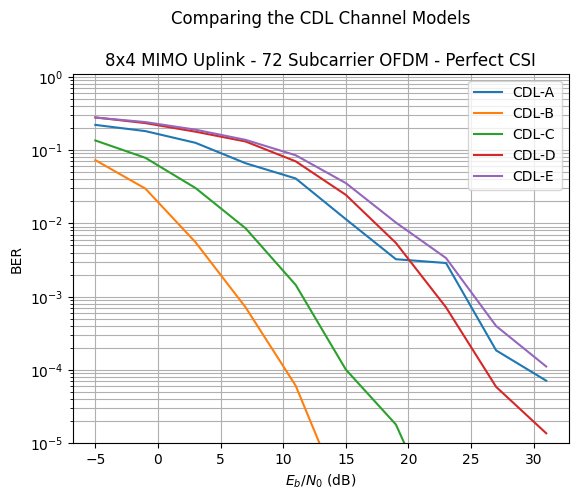

In [ ]:
eps_filename = "sionna_cdl_perfect.eps"

fig = plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.title("Comparing the CDL Channel Models\n\n8x4 MIMO Uplink - 72 Subcarrier OFDM - Perfect CSI");
plt.ylim([1e-5, 1.1])
legend = []
for i, ber in enumerate(UL_P_SIMS["ber"]):
    plt.semilogy(UL_P_SIMS["ebno_db"], ber)
    legend.append("CDL-{}".format(UL_P_SIMS["cdl_model"][i]))
plt.legend(legend);

fig.savefig(eps_filename, format="eps");

In [ ]:
# Comparing CDL Channel Models - Imperfect CSI

UL_SIMS = {
    "ebno_db" : list(np.arange(-5, 35, 4.0)),
    "cdl_model" : ["A", "B", "C", "D", "E"],
    "delay_spread" : 100e-9,
    "perfect_csi" : False,
    "speed" : 0.0,
    "cyclic_prefix_length" : 20,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "duration" : None,
}

start = time.time()

for cdl in UL_SIMS["cdl_model"]:

    model = E2E(cdl_model=cdl,
                  delay_spread=UL_SIMS["delay_spread"],
                  perfect_csi=UL_SIMS["perfect_csi"],
                  speed=UL_SIMS["speed"],
                  cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                  pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"])

    ber, bler = sim_ber(model,
                        UL_SIMS["ebno_db"],
                        batch_size=64,
                        # max_mc_iter=100,
                        max_mc_iter=10,
                        # max_mc_iter=2,
                        num_target_bit_errors=1000,
                        # num_target_bit_errors=100,
                        target_ber=1e-5)

    UL_SIMS["ber"].append(list(ber.numpy()))

UL_SIMS["duration"] = time.time() - start

print("Simulation duration: {:1.2f} [h]".format(UL_SIMS["duration"]/3600))


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.6042e-01 | 1.0000e+00 |      192001 |      737280 |          256 |         256 |        10.1 |reached target bit errors
     -1.0 | 2.2117e-01 | 1.0000e+00 |      163062 |      737280 |          256 |         256 |         5.3 |reached target bit errors
      3.0 | 1.6248e-01 | 1.0000e+00 |      119795 |      737280 |          256 |         256 |         4.9 |reached target bit errors
      7.0 | 1.2221e-01 | 9.8047e-01 |       90106 |      737280 |          251 |         256 |         5.0 |reached target bit errors
     11.0 | 6.4248e-02 | 9.2578e-01 |       47369 |      737280 |          237 |         256 |         5.1 |reached target bit errors
     15.0 | 3.2859e-02 | 8.5156e-01 |       24226 |      737280 |          

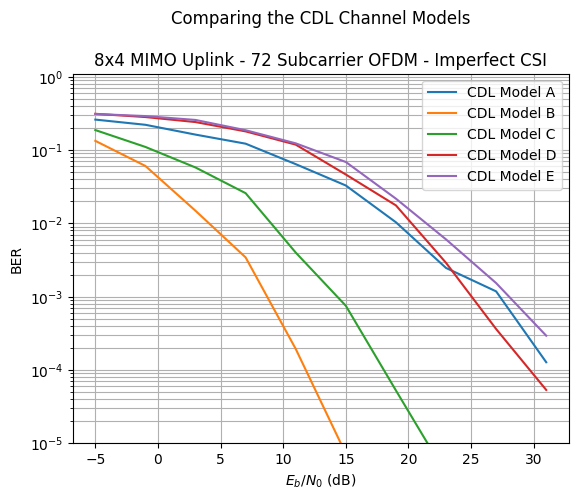

In [ ]:
eps_filename = "sionna_cdl_imperfect.eps"

fig = plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.title("Comparing the CDL Channel Models\n\n8x4 MIMO Uplink - 72 Subcarrier OFDM - Imperfect CSI");
plt.ylim([1e-5, 1.1])
legend = []
for i, ber in enumerate(UL_SIMS["ber"]):
    plt.semilogy(UL_SIMS["ebno_db"], ber)
    legend.append("CDL Model {}".format(UL_SIMS["cdl_model"][i]))
plt.legend(legend);

fig.savefig(eps_filename, format="eps");

In [ ]:
# Evaluating High-Mobility Effects

MOBILITY_SIMS = {
    "ebno_db" : list(np.arange(-5, 35, 4.0)),
    "cdl_model" : "D",
    "delay_spread" : 100e-9,
    "perfect_csi" : [True, False],
    "speed" : [0.0, 20.0],
    "cyclic_prefix_length" : 6,
    "pilot_ofdm_symbol_indices" : [[0]],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for pilot_indices in MOBILITY_SIMS["pilot_ofdm_symbol_indices"]:
  for perfect_csi in MOBILITY_SIMS["perfect_csi"]:
      for speed in MOBILITY_SIMS["speed"]:

          model = E2E(cdl_model=MOBILITY_SIMS["cdl_model"],
              delay_spread=MOBILITY_SIMS["delay_spread"],
              perfect_csi=perfect_csi,
              speed=speed,
              cyclic_prefix_length=MOBILITY_SIMS["cyclic_prefix_length"],
              pilot_ofdm_symbol_indices=pilot_indices)

          ber, bler = sim_ber(model,
                          MOBILITY_SIMS["ebno_db"],
                          batch_size=64,
                          max_mc_iter=10,
                          num_target_bit_errors=1000,
                          target_ber=1e-5)

          MOBILITY_SIMS["ber"].append(list(ber.numpy()))

MOBILITY_SIMS["duration"] = time.time() - start

print("Simulation duration: {:1.2f} [h]".format(MOBILITY_SIMS["duration"]/3600))


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.6324e-01 | 1.0000e+00 |      210255 |      798720 |          256 |         256 |         6.5 |reached target bit errors
     -1.0 | 2.2200e-01 | 1.0000e+00 |      177314 |      798720 |          256 |         256 |         2.5 |reached target bit errors
      3.0 | 1.7747e-01 | 1.0000e+00 |      141748 |      798720 |          256 |         256 |         2.6 |reached target bit errors
      7.0 | 1.0762e-01 | 1.0000e+00 |       85959 |      798720 |          256 |         256 |         2.6 |reached target bit errors
     11.0 | 5.0026e-02 | 9.9609e-01 |       39957 |      798720 |          255 |         256 |         2.7 |reached target bit errors
     15.0 | 1.6491e-02 | 9.3359e-01 |       13172 |      798720 |          

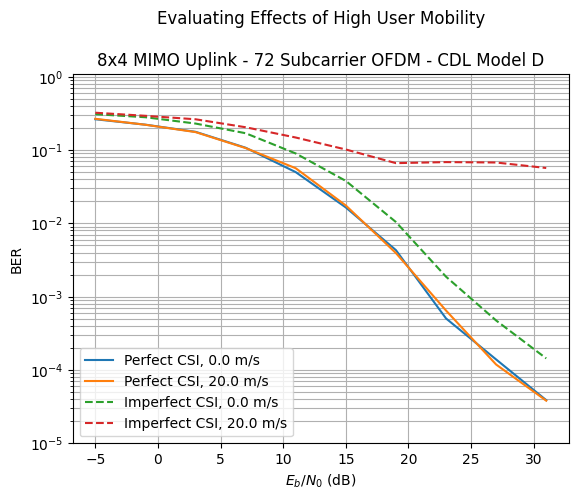

In [ ]:
eps_filename = "sionna_mobility.eps"

fig = plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.title("Evaluating Effects of High User Mobility\n\n8x4 MIMO Uplink - 72 Subcarrier OFDM - CDL Model D");

i = 0
for pilot_indices in MOBILITY_SIMS["pilot_ofdm_symbol_indices"]:
  for perfect_csi in MOBILITY_SIMS["perfect_csi"]:
      for speed in MOBILITY_SIMS["speed"]:
          style = "{}".format("-" if perfect_csi else "--")
          # s = "{} CSI, {} m/s, {}".format("Perfect" if perfect_csi else "Imperfect", speed, "Many Pilots" if len(pilot_indices) > 1 else "Few Pilots")
          s = "{} CSI, {} m/s".format("Perfect" if perfect_csi else "Imperfect", speed)
          plt.semilogy(MOBILITY_SIMS["ebno_db"],
                      MOBILITY_SIMS["ber"][i],
                        style, label=s,)
          i += 1
plt.legend();
plt.ylim([1e-5, 1.1]);

fig.savefig(eps_filename, format="eps");